# Biodiversity Intactness Index Change in Phoenix, AZ (2017-2020)

### By Kaiju Morquecho

[Github Repository](https://github.com/kaimorquecho/eds220_biodiversity_phoenix_az.git)

### Repository Structure 
```
├── .gitignore
├── biodiversity_intactness_arizona.ipynb
├── README.md
└── data  
    │   tl_2020_04_countsub
        | tl_2020_04_countsub.shp
```

### About

This repository will investigate the impacts of urban expansion by analyzing a dataset that captures values for the Biodiversity Intactness Index (BII). The analysis finds changes in BII in the Phoenix county subdivision area between 2017 and 2020 to demonstrate how urban growth affects biodiversity over time. The analysis is a result of the final project for course EDS 220, Working with Environmental Datasets, taught by Dr. Carmen Galaz Garcia and Annie Adams.

<div style="text-align: center;">
  <img src="https://arizona-content.usedirect.com/storage1/gallery/3A31D7D859F14752BB8D987B1300EDBB/medium.jpg"
       alt="roadrunner"
       width="400">
  <p style="font-size: 0.9em; color: gray;">
    Roadrunner in Arizona. Source: Arizona Game & Fish Department.
  </p>
</div>


### Learning Highlights 
- Access BII rasters from the Microsoft Planetary Computer STAC catalog directly from Python via the Microsoft Planetary Computer STAC API and clip them to Phoenix boundaries
- Identify and visualize areas of high biodiversity intactness in Phoenix from 2017 to 2020 with contextual basemaps
- Calculate and visualize areas of loss of high-quality habitat over time via raster masks and pixel counts

### Takeaways 
The BII analysis reveals pronounced spatial disparities in ecological condition across Phoenix:

- Lower BII values are concentrated in highly urbanized and developed areas, indicating reduced biodiversity intactness in regions experiencing greater human pressure.
- Areas with higher BII values tend to occur in less developed or peripheral zones, where habitat quality has been comparatively better preserved.

Together, these findings highlight the uneven distribution of biodiversity impacts within urban environments. Maricopa County experienced the largest increase in developed land compared to all U.S counties between 2001-2021. The results of this analysis provide further evidence of the negative effects of urban expansion on habitat conservation. 

### Data

- The **Biodiversity Intactness Index (BII) Time Series** is a biodiversity indicator that measures changes in biodiversity using abundance data on plants, fungi, and animals. As a time series, the **BII** captures the effects of human interaction and resource use on species abundance over time. The **BII** collection, ID `io-biodiversity`, can be accessed by signing into the **[Microsoft Planetary Computer (MPC)](https://planetarycomputer.microsoft.com/dataset/io-biodiversity)** using the `pystac-client` library to query the STAC API. The `planetary computer` signs items.

- The Phoenix, AZ subdivision area polygon is obtained from the U.S Census Bureau TIGER Shapefile of Arizona County Subdivisions, and is used to outline the area of interest in this analysis. The data can be accessed on the [Data.gov website](https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision) and is titled 'TIGER/Line Shapefile, Current, State of Arizona: County Subdivisions'.

### Data Setup
To run the Phoenix Biodiversity Intactness Index analysis notebook, the data must be organized as follows. First, create a folder named 'data' in the same directory as this notebook. Next, download the required datasets as described in the **Data** section and place all downloaded files (TIGER Shapefiles) inside the data folder. Once the data are stored in this location, the notebook will be able to load the files using relative paths and run without modification.

### References 
Microsoft Planetary Computer. (n.d.). io-biodiversity [STAC collection]. Accessed December 4, 2025, from https://planetarycomputer.microsoft.com/dataset/io-biodiversity

U.S. Census Bureau. (2021). TIGER/Line Shapefile, Current, State of Arizona: County Subdivisions [Data set]. Data.gov. Accessed December 4, 2025, from https://catalog.data.gov/dataset/tiger-line-shapefile-current-state-arizona-county-subdivision

Galaz Garcia, C., & Adams, A. (2025). EDS 220: Working with environmental datasets [Course website]. University of California, Santa Barbara, Master of Environmental Data Science Program. https://meds-eds-220.github.io/MEDS-eds-220-course/

### Import Libraries and Load Datasets

Aside from the standard libraries such as `numpy` and `matplotlib`, the following specialized libraries were used in this analysis:
- `xarray` to access and analyze netCDF4 files (multidimensional datasets)
- `rioxarray` to extend `xarray` with the `rio` accessor to read and manipulate raster data 
- `contextily` to add basemaps to geospatial visualizations
- `geopandas` to handle vector data such as shapefiles
- `planetary_computer` and `pystac_client` to sign into and retrieve items from the Microsoft Planetary Computer STAC 

In [1]:
# Load libraries 
import numpy as np
import matplotlib.pyplot as plt 
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rioxr
import contextily as ctx # For a basemap
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap # To ensure visualization shows bright red


from pystac_client import Client # To access STAC catalogs

import planetary_computer # To sign items from MPC STAC

from IPython.display import Image # For nicer image display

### Access the Biodiversity Intactness Index Collection 

To begin working with the Biodiversity Intactness data, I first connect to the Microsoft Planetary Computer (MPC) STAC API using `Client.open`, which allows me to search and retrieve the geospatial datasets. Because I am specifically interested in changes within Phoenix, Arizona, I define a bounding box of the geographic extent of the Phoenix subdivision. I also specify the years I want to examine (2017 and 2020), since the `io-biodiversity` collection includes multiple years of data.

In [2]:
# Access MPC catalog 
catalog = Client.open(
"https://planetarycomputer.microsoft.com/api/stac/v1",
modifier=planetary_computer.sign_inplace
)

# Access the 'io-biodiversity' STAC collection to view its metadata
bio_collection = catalog.get_child('io-biodiversity')
bio_collection

<CollectionClient id=io-biodiversity>

In [3]:
# View spatial and temporal infomration cleanly
print(f'Spatial Extent:\n {bio_collection.extent.spatial.bboxes}')
print(f'Temporal Extent:\n {bio_collection.extent.temporal.intervals}')


Spatial Extent:
 [[-180, -90, 180, 90]]
Temporal Extent:
 [[datetime.datetime(2017, 1, 1, 0, 0, tzinfo=tzutc()), datetime.datetime(2020, 12, 31, 23, 59, 59, tzinfo=tzutc())]]


### Search Only for Collection Items in Phoenix
To limit the search to relevant data, I define a bounding box encompassing the Phoenix metropolitan area and use it as a spatial filter when querying the io-biodiversity collection. This ensures that only collection items overlapping the area of interest are returned.

In [4]:
# Create a bounding box covering the Phoenix subdivision area
bbox = [-112.826843,32.974108,
        -111.184387,33.863574]

In [5]:
# Search once for all items in bbox
search = catalog.search(
    collections=["io-biodiversity"],
    bbox=bbox)

# Convert the search results into an object
items = search.item_collection()

print(f"Total items returned in search: {len(items)}")

Total items returned in search: 4


### Identify STAC Items for 2017 and 2020 BII Data
I identify the STAC items corresponding to the 2017 and 2020 BII datasets by filtering the returned items based on year information contained in their item ID

In [6]:
# Identify the STAC item containing BII data for 2017 and 2020 by matching the year in the item ID
item_2017 = [i for i in items if "2017" in i.id][0]
item_2020 = [i for i in items if "2020" in i.id][0]

### Load Raster Data Using rioxarray

After identifying the relevant STAC items, I access the raster assets associated with each item and load them into xarray DataArrays using `rioxarray`. This step reads the geospatial raster data and preserves spatial metadata such as coordinate reference systems, resolution, and spatial extent



In [7]:
# Open rasters with rioxarray
phoenix_2017 = rioxr.open_rasterio(item_2017.assets["data"].href)
phoenix_2020 = rioxr.open_rasterio(item_2020.assets["data"].href)

To understand the structure of the raster data, I inspect the dimensions and coordinates of the 2017 Phoenix raster. This revealed the presence of a `band` dimension with length one. This band does not provide any useful information and will only complicate data visualization down the line. I use the `squeeze()` method to simplify the data structure.


In [8]:
print(phoenix_2017.dims,phoenix_2017.coords, '\n')

('band', 'y', 'x') Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 



In [9]:
# Drop length 1 dimension ('band')
phoenix_2017 = phoenix_2017.squeeze() 
phoenix_2020 = phoenix_2020.squeeze() 

# Drop coordinates associated to band
phoenix_2017 = phoenix_2017.drop_vars('band') 
phoenix_2020 = phoenix_2020.drop_vars('band') 

# Check dims and coords to verify band was dropped
print(phoenix_2017.dims,phoenix_2017.coords, '\n')


('y', 'x') Coordinates:
  * x            (x) float64 64kB -115.4 -115.4 -115.4 ... -108.2 -108.2 -108.2
  * y            (y) float64 64kB 34.74 34.74 34.74 34.74 ... 27.57 27.57 27.57
    spatial_ref  int64 8B 0 



### Summary of Data Exploration
To explore the dataset, I accessed the io-biodiversity collection from the Microsoft Planetary Computer STAC API. From the metadata, I learned that this collection provides global coverage (spatial extent: −180° to 180° longitude and −90° to 90° latitude), and includes layers from 2017 through 2020. These years match with the years of interest in this analysis.

When I inspected the STAC item structure, I found that the actual raster data is stored in the "data" asset for each item. Using the asset link (href), I loaded the 2017 and 2020 Biodiversity Intactness rasters directly with `rioxarray.open_rasterio()`. 

### Load the Phoenix Subdivision Shapefile and Use it to Clip Each Raster to the Phoenix Subdivision
To focus the analysis, I load and use the Arizona county subdivision census shapefile and filter it to Phoenix. I will use the shapefile to clip the BII rasters later in the code. This will ensure that calculations and visualizations I perform are limited to the Phoenix, AZ geographic area.

In [10]:
# Load data and filter to Phoenix
phoenix_shape = gpd.read_file('data/tl_2024_04_cousub/tl_2024_04_cousub.shp').query("NAME == 'Phoenix'")

phoenix_shape = phoenix_shape.to_crs(phoenix_2017.rio.crs)

I preview the Phoenix raster and add a basemap for spatial context:

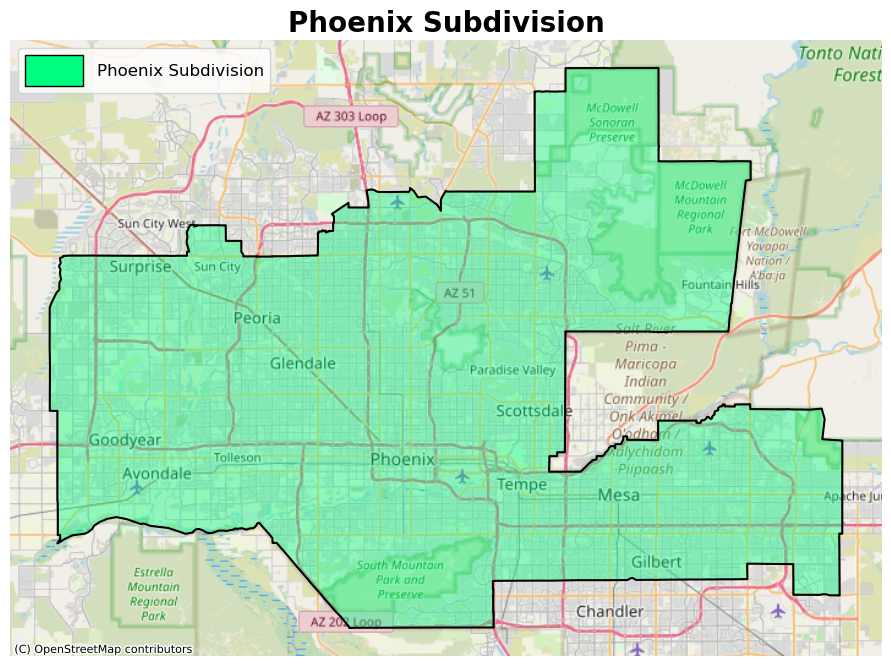

In [11]:
# Take a look at the Phoenix subdivision

# Set phoenix_shape crs to epsg 3857 to match basemap's Web Mercator crs
phoenix_shape_web = phoenix_shape.to_crs(epsg=3857) 

fig, ax = plt.subplots(figsize=(12, 8))

ax.axis('off')

# Phoenix plot
phoenix_shape_web.plot(ax=ax, 
                      color = 'springgreen',
                      alpha = 0.4,
                      )
phoenix_shape_web.boundary.plot(ax=ax, 
                                color = 'black')

# Title
plt.title("Phoenix Subdivision",
         fontsize = 20, 
         fontweight = 'bold')


# Create proxy legend handle
phoenix_patch = mpatches.Patch(
    facecolor="springgreen",
    edgecolor="black",
    label="Phoenix Subdivision"
)

phoenix_leg = ax.legend(
    handles=[phoenix_patch],
    loc="upper left",
    frameon=True,
    fontsize=12,
    handlelength=3.5,
    handleheight=2.5
)

phoenix_leg.get_frame().set_facecolor("white")

# Add basemap for context
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik,
               zoom=10) 


In preparation for calculating BII values, I clip the rasters: 

In [12]:
# Clip each raster to the Phoenix subdivision:
phoenix_2017 = phoenix_2017.rio.clip_box(*phoenix_shape.total_bounds).rio.clip(phoenix_shape.geometry)
phoenix_2020 = phoenix_2020.rio.clip_box(*phoenix_shape.total_bounds).rio.clip(phoenix_shape.geometry)

### Calculate the Percentage of High-Quality Habitat Within Phoenix
To quantify the extent of high-quality habitat within Phoenix, I calculate the percentage of pixels with a Biodiversity Intactness Index (BII) value greater than or equal to 0.75 for each year.

I use boolean masks to identify pixels that meet this threshold. Then, I divide the total number of high-BII pixelsby the total number of valid pixels within the Phoenix boundary, using the original clipped raster to ensure that the calculation is restricted to the Phoenix area. 

In [13]:
# Create boolean mask of high-quality habitat (BII ≥ 0.75) for each year
high_bii_2017 = phoenix_2017 >= 0.75
high_bii_2020 = phoenix_2020 >= 0.75

In [14]:
# Calculate the percentage of Phoenix pixels that have high BII (≥ 0.75)
pct_2017 = (high_bii_2017.sum() / phoenix_2017.count()) * 100
pct_2020 = (high_bii_2020.sum() / phoenix_2020.count()) * 100


print(f"2017 High-BII: {pct_2017.item():.2f}%")
print(f"2020 High-BII: {pct_2020.item():.2f}%")


2017 High-BII: 7.13%
2020 High-BII: 6.49%


In [15]:
# Loss occurs where pixels were high BII in 2017 but not in 2020
loss_mask = high_bii_2017 & (~high_bii_2020)

# Convert to numeric mask for plotting (1 = loss, NaN = elsewhere)
loss_plot = loss_mask.astype(float).where(loss_mask, np.nan)

### Visualize 2020 BII with High-Quality Habitat Loss

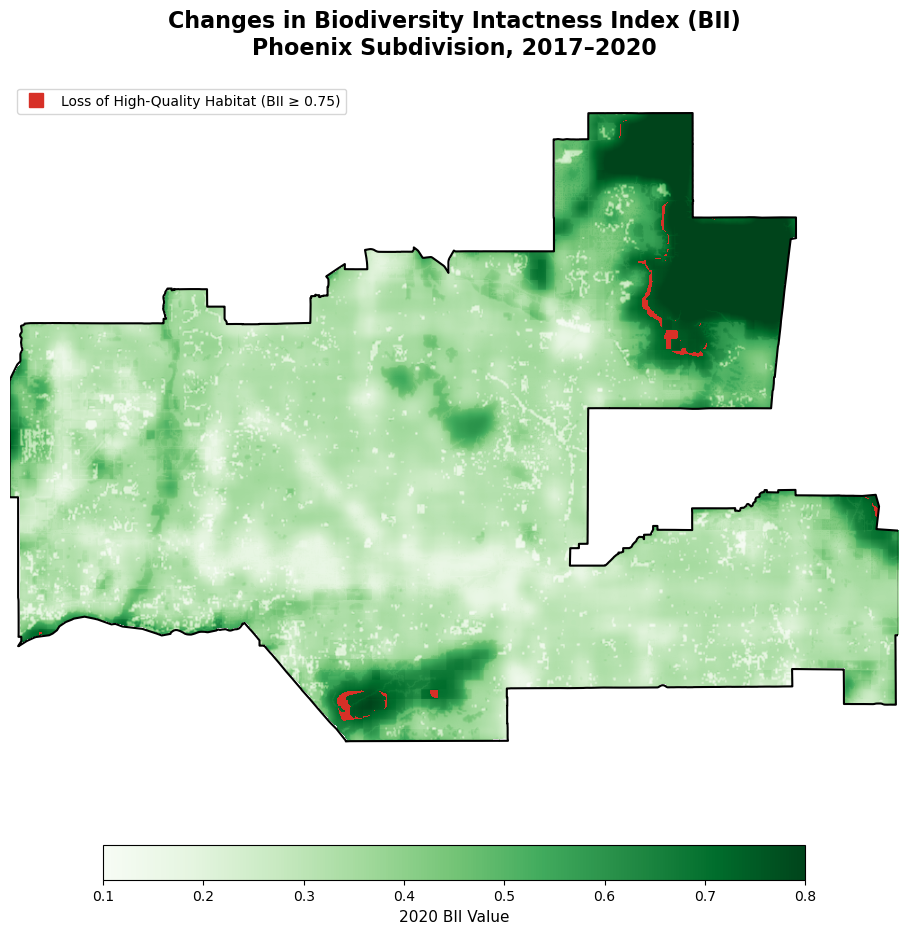

In [16]:
fig, ax = plt.subplots(figsize=(12, 10))

# Plot 2020 BII as background
bii_img = ax.imshow(
    phoenix_2020.squeeze().values,
    cmap="Greens",
    vmin=0.1,
    vmax=0.8,
    extent=[
        phoenix_2020.x.min(),
        phoenix_2020.x.max(),
        phoenix_2020.y.min(),
        phoenix_2020.y.max()
    ],
    origin="upper",
    aspect="auto"
)

# Plot loss areas in red
red_cmap = ListedColormap(["#d73027"])

ax.imshow(
    loss_plot.values,
    cmap=red_cmap,
    vmin=0,
    vmax=1,
    extent=[
        loss_plot.x.min(),
        loss_plot.x.max(),
        loss_plot.y.min(),
        loss_plot.y.max()
    ],
    origin="upper",
    aspect="auto"
)

# Phoenix boundary
phoenix_shape.boundary.plot(
    ax=ax,
    color="black",
    linewidth=1.5
)

# Add a colorbar
cbar = plt.colorbar(
    bii_img,
    ax=ax,
    orientation="horizontal",
    pad=0.08,
    shrink=0.6
)
# Label colorbar
cbar.set_label("2020 BII Value",
               fontsize=11)

# Title and legend
ax.set_title(
    "Changes in Biodiversity Intactness Index (BII)\n"
    "Phoenix Subdivision, 2017–2020",
    fontsize=16,
    fontweight="bold",
    pad=20
)

ax.plot(
    [], [],
    marker="s",
    color="#d73027",
    linestyle="",
    markersize=10,
    label="Loss of High-Quality Habitat (BII ≥ 0.75)"
)
ax.legend(loc="upper left",
          frameon=True)

ax.axis("off")
plt.tight_layout()
plt.show()


### Map Analysis

The map shows that the Phoenix subdivision experienced a general decline in high-intactness habitat (dark green) from 2017 to 2020, with the proportion of high-quality habitat decreasing from 7.13% to 6.49% of the total city area. Although these percentages are relatively small, the spatial pattern of loss highlights localized areas where ecological conditions appear to be worsening.

These localized losses are consistent with patterns of urban expansion occurring across Arizona, particularly around the edges of the city. Areas that previously supported relatively intact habitat have been converted to residential and commercial development, reducing the extent of unaltered land capable of supporting native plant and animal species.

The red areas on the map represent locations where ecological integrity fell below the high-quality threshold between 2017 and 2020. If urban development continues at similar rates, it is likely that additional portions of Phoenix will experience comparable declines in biodiversity intactness over time.